In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import sys
sys.path.insert(0, "../input/weightedboxesfusion")
from ensemble_boxes import *
import glob

In [2]:
# !ls ../input/yolov5git/yolov5/utils/

In [3]:
!cp -r ../input/yolov5tta/yolov5tta/* .
!cp -r ../input/yolov5git/yolov5/utils/* ./utils/

In [4]:
%%time
import argparse

from utils.datasets import *
from utils.utils import *


def detect(save_img=False):
    weights, imgsz = opt.weights,opt.img_size
    source = '../input/global-wheat-detection/test/'
    
    # Initialize
    device = torch_utils.select_device(opt.device)
    half = False
    # Load model
    models = []
    for w in weights:
        models.append(torch.load(w, map_location=device)['model'].to(device).float().eval())


    dataset = LoadImages(source, img_size=1024)

    # Get names and colors

    # Run inference
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    all_path=[]
    all_bboxex =[]
    all_score =[]
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        bboxes_2 = []
        score_2 = []
        for model in models:
            pred = model(img, augment=opt.augment)[0]
            pred = non_max_suppression(pred, 0.4, opt.iou_thres,fast=True, classes=None, agnostic=False)
            t2 = torch_utils.time_synchronized()

            bboxes = []
            score = []
            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, '', im0s
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class

                    for *xyxy, conf, cls in det:
                        if True:  # Write to file
                            xywh = torch.tensor(xyxy).view(-1).numpy()  # normalized xywh
#                             xywh[2] = xywh[2]-xywh[0]
#                             xywh[3] = xywh[3]-xywh[1]
                            bboxes.append(xywh)
                            score.append(conf)
            bboxes_2.append(bboxes)
            score_2.append(score)
        all_path.append(path)
        all_score.append(score_2)
        all_bboxex.append(bboxes_2)
    return all_path,all_score,all_bboxex



class opt:
    weights_folds = list(glob.glob("../input/yolov5pth/*"))
    weights_folds.sort()
    weights = weights_folds[4:]
    img_size = 1024
    conf_thres = 0.1
    iou_thres = 0.94
    augment = True
    device = '0'
    classes=None
    agnostic_nms = True
        
opt.img_size = check_img_size(opt.img_size)


with torch.no_grad():
    res = detect()

Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)



/opt/conda/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.common.Conv' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


image 1/10 ../input/global-wheat-detection/test/2fd875eaa.jpg: image 2/10 ../input/global-wheat-detection/test/348a992bb.jpg: image 3/10 ../input/global-wheat-detection/test/51b3e36ab.jpg: image 4/10 ../input/global-wheat-detection/test/51f1be19e.jpg: image 5/10 ../input/global-wheat-detection/test/53f253011.jpg: image 6/10 ../input/global-wheat-detection/test/796707dd7.jpg: image 7/10 ../input/global-wheat-detection/test/aac893a91.jpg: image 8/10 ../input/global-wheat-detection/test/cb8d261a3.jpg: image 9/10 ../input/global-wheat-detection/test/cc3532ff6.jpg: image 10/10 ../input/global-wheat-detection/test/f5a1f0358.jpg: CPU times: user 10.3 s, sys: 4.14 s, total: 14.4 s
Wall time: 19.8 s


In [5]:
def run_wbf(boxes,scores, image_size=1024, iou_thr=0.4, skip_box_thr=0.34, weights=None):
    labels0 = [np.ones(len(scores[idx])) for idx in range(len(scores))]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels0, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return boxes, scores, labels

In [6]:
all_path,all_score,all_bboxex = res

In [7]:
results =[]
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)
for row in range(len(all_path)):
    image_id = all_path[row].split("/")[-1].split(".")[0]
    boxes = all_bboxex[row]
    scores = all_score[row]
    boxes, scores, labels = run_wbf(boxes,scores)
    boxes = (boxes*1024/1024).astype(np.int32).clip(min=0, max=1023)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    result = {'image_id': image_id,'PredictionString': format_prediction_string(boxes, scores)}
    results.append(result)
!rm -rf *
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,2fd875eaa,0.7405 942 646 80 103 0.7376 0 737 88 104 0.72...
1,348a992bb,0.7225 733 222 140 88 0.7206 598 445 121 95 0....
2,51b3e36ab,0.7388 462 15 85 138 0.6961 335 460 83 152 0.6...
3,51f1be19e,0.6160 503 467 192 108 0.6126 773 884 143 101 ...
4,53f253011,0.7365 139 623 91 123 0.7206 467 461 151 199 0...


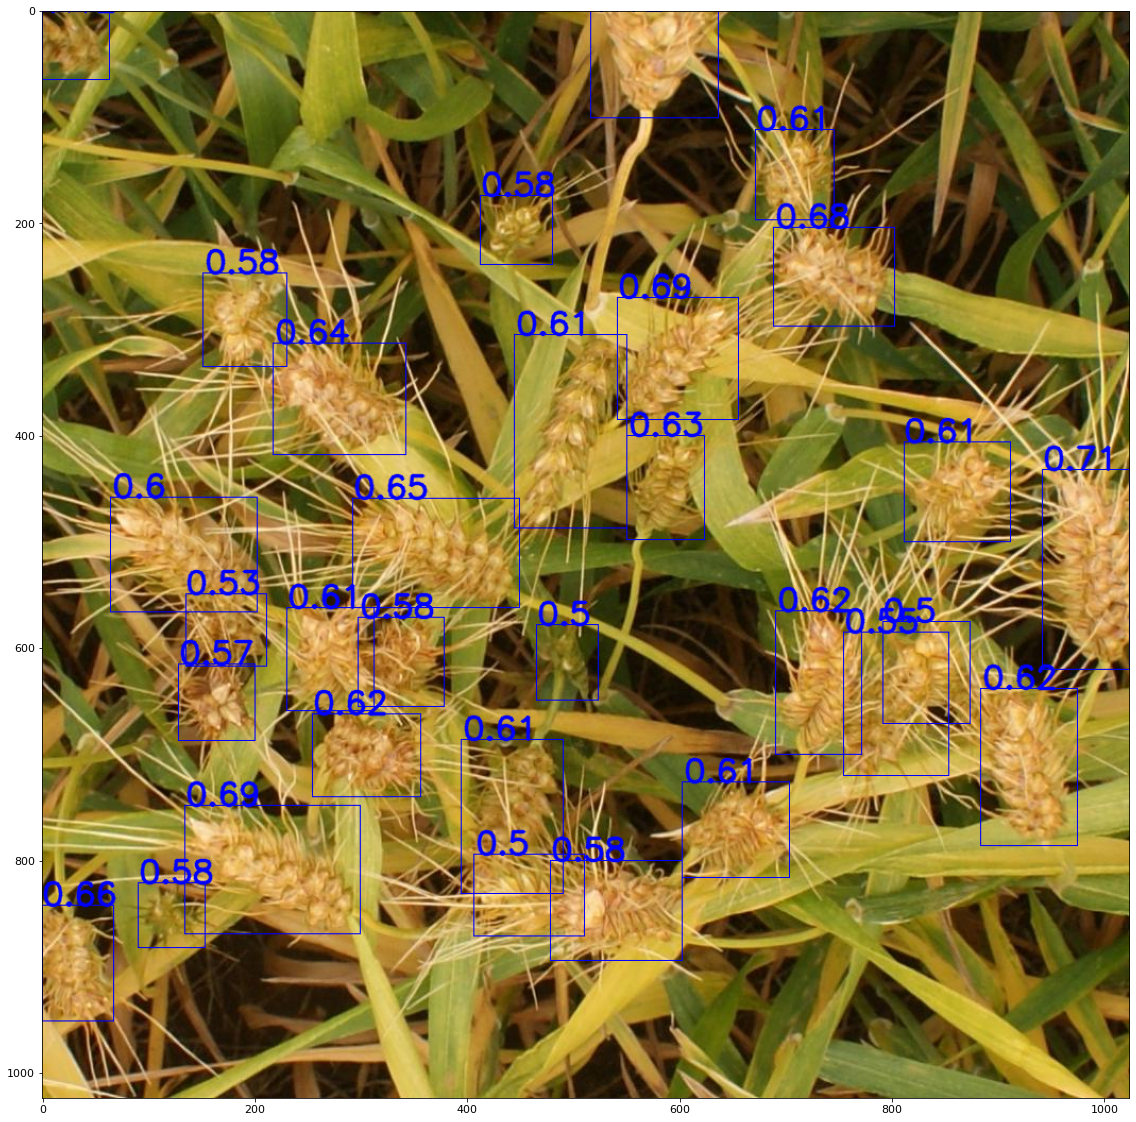

In [8]:
size = 300
idx =-1
font = cv2.FONT_HERSHEY_SIMPLEX 
image = image = cv2.imread(all_path[idx], cv2.IMREAD_COLOR)
fontScale = 1
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2
for b,s in zip(boxes,scores):
    image = cv2.rectangle(image, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), (255,0,0), 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (b[0]+np.random.randint(3),b[1]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()